In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os
from os import walk
for (dirpath, dirnames, filenames) in walk("./DATASET"):
    print("Directory path: ", dirpath)
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
# pip install tensorflow_addons==0.10.0

Directory path:  ./DATASET
Directory path:  ./DATASET/TEST
Directory path:  ./DATASET/TEST/downdog
Directory path:  ./DATASET/TEST/goddess
Directory path:  ./DATASET/TEST/plank
Directory path:  ./DATASET/TEST/tree
Directory path:  ./DATASET/TEST/warrior2
Directory path:  ./DATASET/TRAIN
Directory path:  ./DATASET/TRAIN/downdog
Directory path:  ./DATASET/TRAIN/goddess
Directory path:  ./DATASET/TRAIN/plank
Directory path:  ./DATASET/TRAIN/tree
Directory path:  ./DATASET/TRAIN/warrior2


In [2]:
train_path = "./DATASET/TRAIN"
test_path = "./DATASET/TEST"

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1 / 255.0,
                                   rotation_range = 10, 
                                   zoom_range = 0.30, 
                                   shear_range = 0.30,
                                   fill_mode = "nearest", 
                                   validation_split=0.20
                                  )
test_datagen = ImageDataGenerator(rescale=1 / 255.0)

In [4]:

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

batch_size = 8
train_generator = train_datagen.flow_from_directory(
        directory=train_path,  # this is the target directory
        color_mode="rgb",
        target_size=(224, 224),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='sparse',  # since we use binary_crossentropy loss, we need binary labels
        subset='training',
        shuffle=True,
        seed=42)

# this is a similar generator, for validation data
validation_generator = train_datagen.flow_from_directory(
        directory=train_path,
        color_mode="rgb",
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='sparse',
        subset='validation',
        shuffle=True,
        seed=42)

test_generator = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    seed=42)

Found 866 images belonging to 5 classes.
Found 215 images belonging to 5 classes.
Found 470 images belonging to 5 classes.


#### Training an encoder to learn to produce vector representations of input images such that representations of images in the same class will be more similar compared to representations of images in different classes.

### Build the encoder model
#### The encoder model takes the image as input and turns it into a 2048-dimensional feature vector.

In [5]:
input_shape = (224,224,3)
projection_units = 128
learning_rate = 0.0001
temperature = 0.05

In [6]:
def create_encoder():
    resnet = keras.applications.ResNet50V2(
        include_top=False, weights="imagenet", input_shape=input_shape, pooling="avg"
    )

    inputs = keras.Input(shape=input_shape)
    outputs = resnet(inputs)
    model = keras.Model(inputs=inputs, outputs=outputs, name="image-encoder")
    return model


### Build the classification model
#### The classification model adds a fully-connected layer on top of the encoder, plus a softmax layer with the target classes

In [7]:
from tensorflow.keras.optimizers import Adam
num_classes = train_generator.num_classes
def create_classifier(encoder, trainable=True):

    for layer in encoder.layers:
        layer.trainable = trainable

    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    outputs = layers.Dense(num_classes, activation="softmax")(features)

    model = keras.Model(inputs=inputs, outputs=outputs, name="image-classifier")
    epochs = 10
    opt = Adam(learning_rate=learning_rate, decay=learning_rate / (epochs * 0.5))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

### Supervised contrastive learning loss function

In [8]:
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super().__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)


def add_projection_head(encoder):
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    outputs = layers.Dense(projection_units, activation="relu")(features)
    model = keras.Model(
        inputs=inputs, outputs=outputs, name="image-encoder_with_projection-head"
    )
    return model

#### Train only the encoder model

In [9]:
encoder = create_encoder()

encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)

encoder_with_projection_head.summary()

history = encoder_with_projection_head.fit(train_generator,
                    validation_data = validation_generator,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_steps = validation_generator.n//validation_generator.batch_size,
                    epochs=10)

2023-03-27 16:29:53.842612: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-03-27 16:29:54.029120: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-27 16:29:54.029182: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (comp): /proc/driver/nvidia/version does not exist
2023-03-27 16:29:54.031189: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-03-27 16:29:54.038512: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2593905000 Hz
2023-03-27 16:29:54.039301: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8ff0001750 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-03-27 

Model: "image-encoder_with_projection-head"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
image-encoder (Model)        (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
Total params: 23,827,072
Trainable params: 23,781,632
Non-trainable params: 45,440
_________________________________________________________________
Epoch 1/10
108/108 [==============================] - 142s 1s/step - loss: 1.8917 - val_loss: 1.3579
Epoch 2/10
108/108 [==============================] - 139s 1s/step - loss: 1.2909 - val_loss: 1.1938
Epoch 3/10
108/108 [==============================] -

Installation needed

!pip install h5py==2.10.0

In [10]:
classifier = create_classifier(encoder, trainable=False)
history = classifier.fit(train_generator,
                    validation_data = validation_generator,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_steps = validation_generator.n//validation_generator.batch_size,
                    epochs=7)

Epoch 1/7
108/108 [==============================] - 68s 626ms/step - loss: 0.8374 - accuracy: 0.7867 - val_loss: 0.4864 - val_accuracy: 0.9135
Epoch 2/7
108/108 [==============================] - 67s 620ms/step - loss: 0.2499 - accuracy: 0.9848 - val_loss: 0.2926 - val_accuracy: 0.9471
Epoch 3/7
108/108 [==============================] - 67s 620ms/step - loss: 0.1400 - accuracy: 0.9895 - val_loss: 0.2331 - val_accuracy: 0.9615
Epoch 4/7
108/108 [==============================] - 68s 627ms/step - loss: 0.0960 - accuracy: 0.9907 - val_loss: 0.2101 - val_accuracy: 0.9375
Epoch 5/7
108/108 [==============================] - 68s 633ms/step - loss: 0.0674 - accuracy: 0.9942 - val_loss: 0.1488 - val_accuracy: 0.9663
Epoch 6/7
108/108 [==============================] - 68s 628ms/step - loss: 0.0565 - accuracy: 

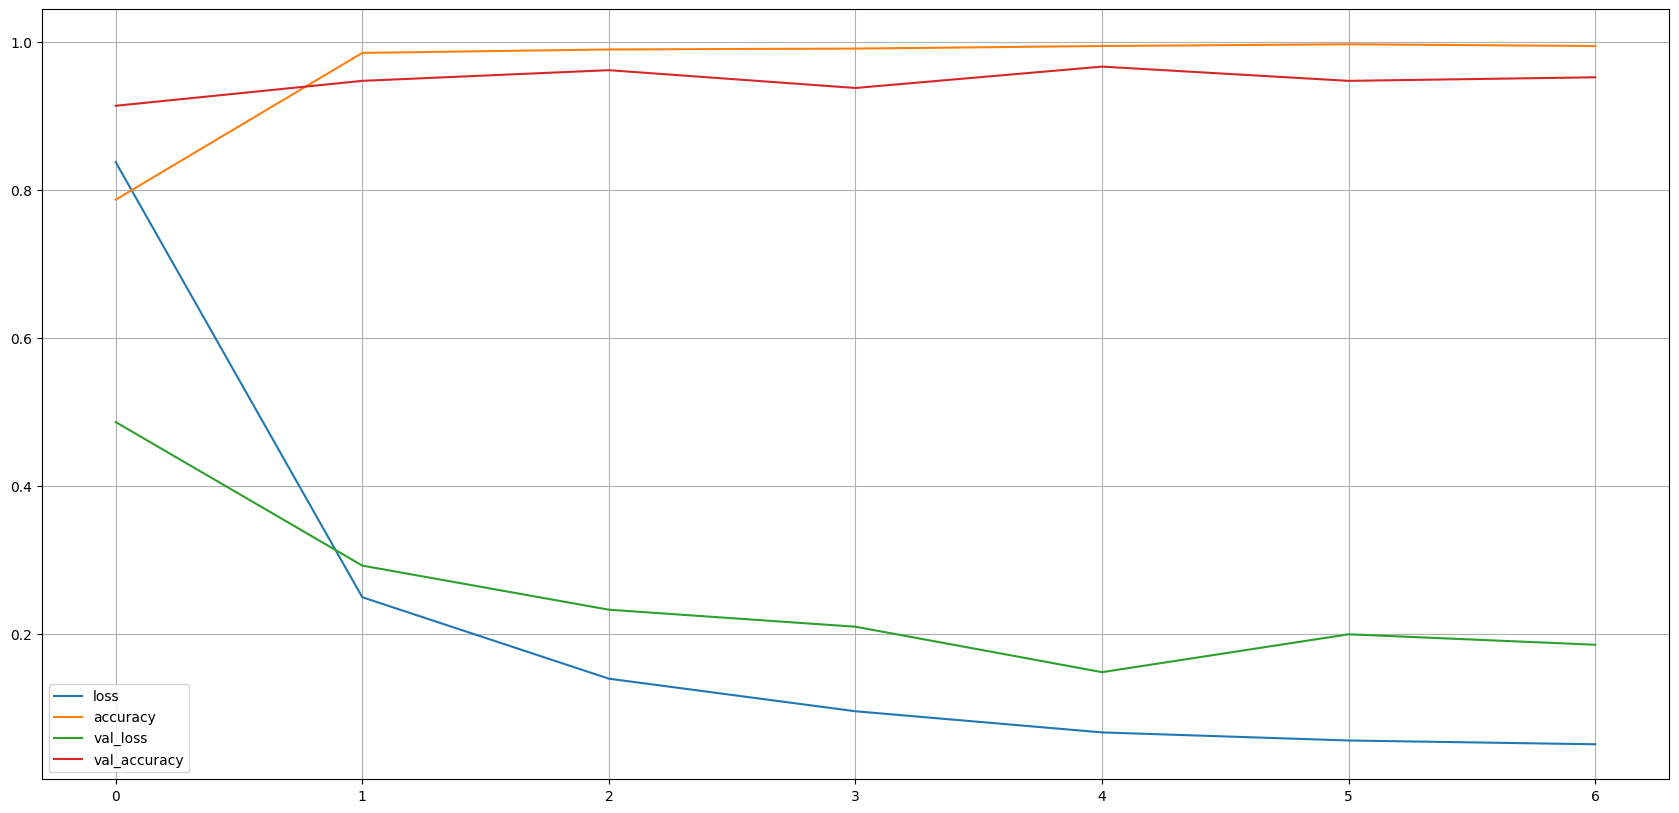

In [11]:
pd.DataFrame(history.history).plot(figsize=(21, 10))
plt.grid(True)
plt.gca()
plt.show()

In [12]:
score = classifier.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

59/59 [==============================] - 40s 682ms/step - loss: 0.0907 - accuracy: 0.9745
Test loss: 0.09072280675172806
Test accuracy: 0.9744681119918823


In [13]:
predict = np.argmax(classifier.predict(test_generator),axis=1)

In [14]:

cnf_matrix = confusion_matrix(test_generator.labels, predict)
print(cnf_matrix)

[[ 95   0   1   0   1]
 [  0  76   2   2   0]
 [  1   0 114   0   0]
 [  0   1   0  68   0]
 [  0   4   0   0 105]]


In [15]:
test_generator.class_indices

{'downdog': 0, 'goddess': 1, 'plank': 2, 'tree': 3, 'warrior2': 4}

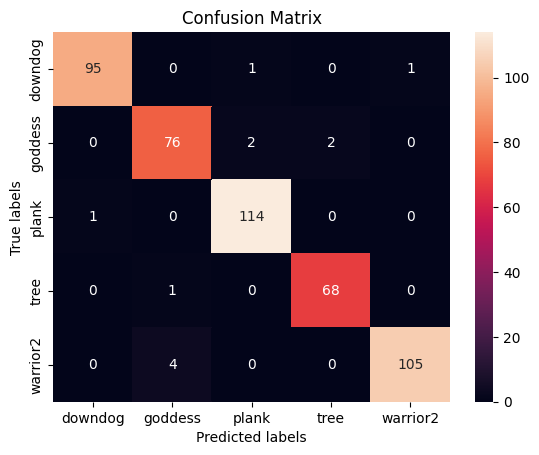

In [16]:

ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['downdog', 'goddess','plank','tree','warrior2']); ax.yaxis.set_ticklabels(['downdog', 'goddess','plank','tree','warrior2']);